# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

import workspace_utils

from pyspark.sql import Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, round, array, isnull, struct
from pyspark.sql.types import ArrayType, StringType, IntegerType, LongType, FloatType

from pyspark import keyword_only
from pyspark.ml import Transformer, Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify application") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read the MINI sparkify dataset
event_data = 'mini_sparkify_event_data.json'

df = spark.read.json(event_data)


In [4]:
# What is the data structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# clearing out data with no reference usable later.
df.where(isnull(df.registration)).select('userId').distinct().show()
df = df.filter(df.userId != '')
df.where(isnull(df.registration)).select('userId').distinct().show()

+------+
|userId|
+------+
|      |
+------+

+------+
|userId|
+------+
+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's first look at the time dimension of the data. In regrads of the time distribution of curn downgrade and upgrade quantities.

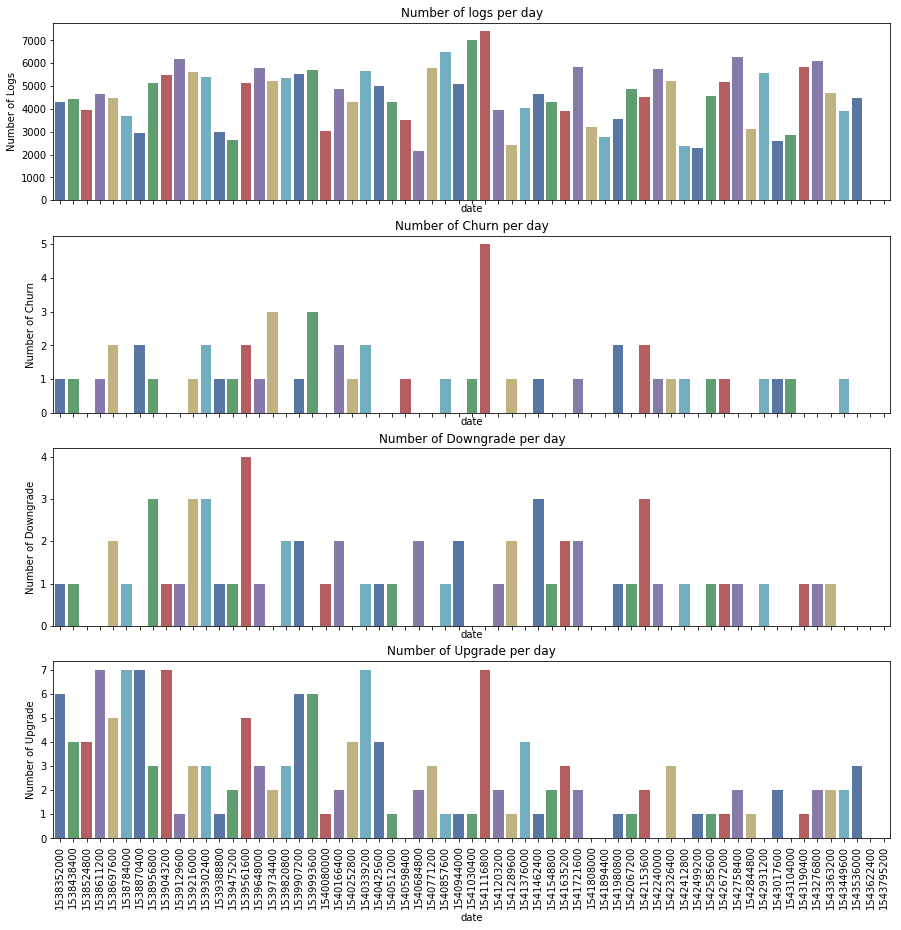

In [6]:
convert_ts_day = udf(lambda x: x//86400000*86400, StringType())
check_Cancellation_Confirmation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
check_Downgrade_Confirmation = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
check_Upgrade_Confirmation = udf(lambda x: 1 if x == 'Submit Upgrade' else 0, IntegerType())
df_graph_date_count = df.select(['ts']).withColumn('date', convert_ts_day(df.ts)).groupBy('date').agg(count('date')).sort('date').toPandas()
df_graph_churn_count = df.select(['ts', 'page']).withColumn('date', convert_ts_day(df.ts)).withColumn('Churn', check_Cancellation_Confirmation(df.page)).groupBy('date').sum().sort('date').toPandas()
df_graph_down_count = df.select(['ts', 'page']).withColumn('date', convert_ts_day(df.ts)).withColumn('Downgrade', check_Downgrade_Confirmation(df.page)).groupBy('date').sum().sort('date').toPandas()
df_graph_up_count = df.select(['ts', 'page']).withColumn('date', convert_ts_day(df.ts)).withColumn('Upgrade', check_Upgrade_Confirmation(df.page)).groupBy('date').sum().sort('date').toPandas()

# Draw the illustration of our result
fig, axs = plt.subplots(4, figsize=(15, 15), sharex=True)
plt.xticks(rotation=90)

axs[0] = sns.barplot(x='date', y='count(date)', data=df_graph_date_count, ax=axs[0], palette='deep')
axs[0].set_title('Number of logs per day')
axs[1] = sns.barplot(x='date', y='sum(Churn)', data=df_graph_churn_count, ax=axs[1], palette='deep')
axs[1].set_title('Number of Churn per day')
axs[2] = sns.barplot(x='date', y='sum(Downgrade)', data=df_graph_down_count, ax=axs[2], palette='deep')
axs[2].set_title('Number of Downgrade per day')
axs[3] = sns.barplot(x='date', y='sum(Upgrade)', data=df_graph_up_count, ax=axs[3], palette='deep')
axs[3].set_title('Number of Upgrade per day')

axs[0].set_ylabel('Number of Logs')
axs[1].set_ylabel('Number of Churn')
axs[2].set_ylabel('Number of Downgrade')
axs[3].set_ylabel('Number of Upgrade')

display(fig)
plt.close('all')

Proportion of churn upgrade and downgrade

In [7]:
wU = Window.partitionBy('userId')
check_Cancellation_Confirmation = udf(lambda x: 'Yes' if x == 'Cancellation Confirmation' else 'No', StringType())
check_Submit_Upgrade = udf(lambda x: 'Yes' if x == 'Submit Upgrade' else 'No', StringType())
check_Submit_Downgrade = udf(lambda x: 'Yes' if x == 'Submit Downgrade' else 'No', StringType())
df2 = df.withColumn('churn', check_Cancellation_Confirmation(col('page'))).withColumn('churn', max('churn').over(wU))\
    .withColumn('upgrade', check_Submit_Upgrade(col('page'))).withColumn('upgrade', max('upgrade').over(wU))\
    .withColumn('downgrade', check_Submit_Downgrade(col('page'))).withColumn('downgrade', max('downgrade').over(wU))

In [8]:
df2.dropDuplicates(['userId']).groupby(['churn']).count().orderBy(desc('churn')).show()
df2.dropDuplicates(['userId']).groupby(['upgrade']).count().orderBy(desc('upgrade')).show()
df2.dropDuplicates(['userId']).groupby(['downgrade']).count().orderBy(desc('downgrade')).show()
df2.dropDuplicates(['userId']).groupby(['churn', 'upgrade', 'downgrade']).count().orderBy(desc('count')).show()

+-----+-----+
|churn|count|
+-----+-----+
|  Yes|   52|
|   No|  173|
+-----+-----+

+-------+-----+
|upgrade|count|
+-------+-----+
|    Yes|  131|
|     No|   94|
+-------+-----+

+---------+-----+
|downgrade|count|
+---------+-----+
|      Yes|   49|
|       No|  176|
+---------+-----+

+-----+-------+---------+-----+
|churn|upgrade|downgrade|count|
+-----+-------+---------+-----+
|   No|     No|       No|   68|
|   No|    Yes|       No|   65|
|   No|    Yes|      Yes|   37|
|  Yes|     No|       No|   22|
|  Yes|    Yes|       No|   21|
|  Yes|    Yes|      Yes|    8|
|   No|     No|      Yes|    3|
|  Yes|     No|      Yes|    1|
+-----+-------+---------+-----+



Was is the level that the user had while entering in the dataset, so on their first ts log.

In [9]:
w = Window.partitionBy('userId')
df.select(['userId', 'ts', 'level']).withColumn('Min_ts', min('ts').over(w)).where(col('ts') == col('Min_ts'))\
    .drop('Min_ts').groupBy('level').agg(count('level')).show()

+-----+------------+
|level|count(level)|
+-----+------------+
| free|         183|
| paid|          48|
+-----+------------+



Which activities (page) are in the logs.

In [10]:
df.select('page').groupBy('page').agg(count('page')).sort(desc('count(page)')).show(99, False)

+-------------------------+-----------+
|page                     |count(page)|
+-------------------------+-----------+
|NextSong                 |228108     |
|Thumbs Up                |12551      |
|Home                     |10082      |
|Add to Playlist          |6526       |
|Add Friend               |4277       |
|Roll Advert              |3933       |
|Logout                   |3226       |
|Thumbs Down              |2546       |
|Downgrade                |2055       |
|Settings                 |1514       |
|Help                     |1454       |
|Upgrade                  |499        |
|About                    |495        |
|Save Settings            |310        |
|Error                    |252        |
|Submit Upgrade           |159        |
|Submit Downgrade         |63         |
|Cancel                   |52         |
|Cancellation Confirmation|52         |
+-------------------------+-----------+



Example of Churn with UserId and ts

In [11]:
df.filter(df.page == 'Cancellation Confirmation').select(['userId', 'ts']).sort(desc('ts')).show()

+------+-------------+
|userId|           ts|
+------+-------------+
|100007|1543491909000|
|100021|1543143782000|
|100015|1543073753000|
|300001|1543009344000|
|100014|1542740649000|
|    53|1542630896000|
|200020|1542472842000|
|200016|1542356278000|
|200017|1542313003000|
|    70|1542234867000|
|    29|1542181031000|
|    54|1542051608000|
|100022|1542038645000|
|200015|1541746863000|
|    28|1541463632000|
|   103|1541340091000|
|100013|1541184816000|
|   106|1541166424000|
|200018|1541153274000|
|200021|1541138333000|
+------+-------------+
only showing top 20 rows



Is there a link between registration date and churn

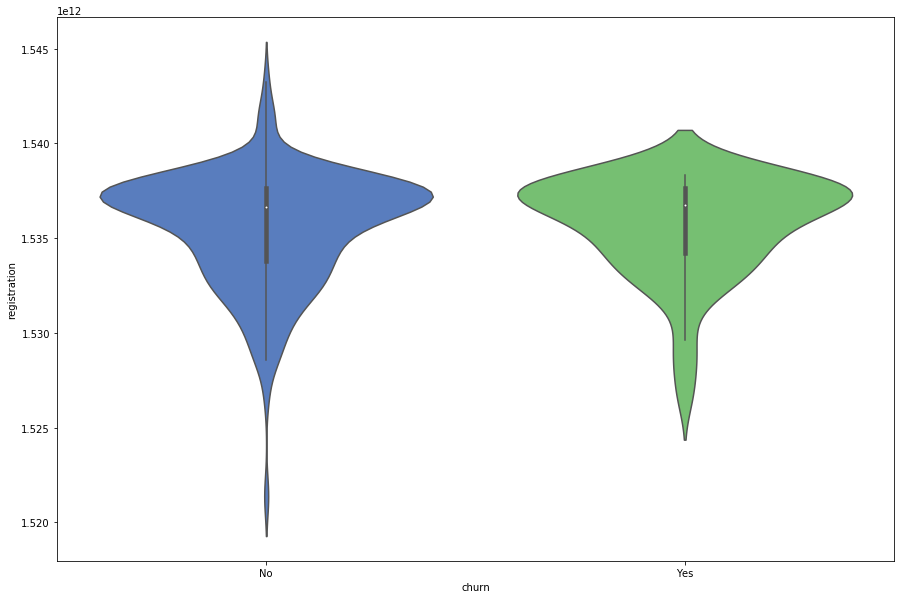

In [12]:
data_for_graph = df2.dropDuplicates(['userId']).toPandas()

fig, ax = plt.subplots(1, figsize=(15, 10))
ax = sns.violinplot(x='churn', y='registration', data=data_for_graph, palette="muted")

display(fig)
plt.close('all')

Is there a link between gender and churn

In [13]:
df2.dropDuplicates(['userId']).groupby(['gender', 'churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M|  Yes|   32|
|     M|   No|   89|
|     F|   No|   84|
|     F|  Yes|   20|
+------+-----+-----+



Is there a link between level and churn

In [14]:
df2.withColumn('Max_ts', max('ts').over(wU)).where(col('Max_ts') == col('ts')).drop('Max_ts')\
        .groupby(['level', 'churn']).count().show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|   No|  115|
| free|   No|   59|
| paid|  Yes|   31|
| free|  Yes|   22|
+-----+-----+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
class Data_bucketer(Transformer, HasInputCol, HasOutputCol):
    '''
    This class is an experimentation on creating custom Transformer. It could have been done in the main code, but 
    I wanted to experiment.
    
    It has 8 Param elements
    inputCol, not used
    outputCol, not used
    bucket_size, size in days of the training bucket
    number_of_bucket_for_training, not implemented yet, but number of trainng buckets
    prediction_date, initial date of prediction, before is training features data, after it is labels data
    number_of_days_predicting_for, size in days of the prediction bucket 
    number_of_duplication, number of ducplication of data by offsetting teh prediction_date
    date_interval, interval of days used for offsetting the prediction date in the duplication process

    The Transform function is the main computorial elements of this class
    
    Logic is as follows
      for this bucket of duplication
          Calculate the date_of_prediction for this given iteration of duplication
          Calculate start_bucket and end_bucket timestamp
          Calculate 'data', which contains all the 'page' counting, plus the over bucket_size period by userId
          Calculate 'data1', which contains latest value over bucket_size period for an userId
          Calculate 'data2', which contains the by session features
          Calculate 'label_columns' over the prediction bucket dates
          
          Join all those dataframe together on columns
          Union of the join with the previous duplication

    '''
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, bucket_size=None, number_of_bucket_for_training=None,
                 prediction_date=None, number_of_days_predicting_for=None, number_of_duplication=None,
                 date_interval=None):
        super(Data_bucketer, self).__init__()
        self.bucket_size = Param(self, "bucket_size", "")
        self.number_of_bucket_for_training = Param(self, "number_of_bucket_for_training", "")
        self.prediction_date = Param(self, "prediction_date", "")
        self.number_of_days_predicting_for = Param(self, "number_of_days_predicting_for", "")
        self.number_of_duplication = Param(self, "number_of_duplication", "")
        self.date_interval = Param(self, "date_interval", "")
        self._setDefault(bucket_size=set(), number_of_bucket_for_training=set(), prediction_date=set(),
                         number_of_days_predicting_for=set(), number_of_duplication=set(), date_interval=set())
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, bucket_size=None, number_of_bucket_for_training=None,
                  prediction_date=None, number_of_days_predicting_for=None, number_of_duplication=None,
                  date_interval=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setbucket_size(self, value):
        self._paramMap[self.bucket_size] = value
        return self

    def getbucket_size(self):
        return self.getOrDefault(self.bucket_size)

    def setnumber_of_bucket_for_training(self, value):
        self._paramMap[self.number_of_bucket_for_training] = value
        return self

    def getnumber_of_bucket_for_training(self):
        return self.getOrDefault(self.number_of_bucket_for_training)

    def setprediction_date(self, value):
        self._paramMap[self.prediction_date] = value
        return self

    def getprediction_date(self):
        return self.getOrDefault(self.prediction_date)

    def setnumber_of_days_predicting_for(self, value):
        self._paramMap[self.number_of_days_predicting_for] = value
        return self

    def getnumber_of_days_predicting_for(self):
        return self.getOrDefault(self.number_of_days_predicting_for)

    def setnumber_of_duplication(self, value):
        self._paramMap[self.number_of_duplication] = value
        return self

    def getnumber_of_duplication(self):
        return self.getOrDefault(self.number_of_duplication)

    def setdate_interval(self, value):
        self._paramMap[self.date_interval] = value
        return self

    def getdate_interval(self):
        return self.getOrDefault(self.date_interval)

    def _transform(self, dataset):
        bucket_size = self.getbucket_size()
        number_of_bucket_for_training = self.getnumber_of_bucket_for_training()
        prediction_date = self.getprediction_date()
        number_of_days_predicting_for = self.getnumber_of_days_predicting_for()
        number_of_duplication = self.getnumber_of_duplication()
        date_interval = self.getdate_interval()
        
        # start_time = time.time()

        # pass_not_null = udf(lambda x: x[0] if x[0] is not None else x[1], StringType())

        for iteration in range(number_of_duplication + 1):
            
            # calculate the date of prediction for this duplication
            date_of_prediction = prediction_date - 86400000 * date_interval * iteration

            # calculate the start and end timestamp
            start_bucket = date_of_prediction - 86400000 * bucket_size
            end_bucket = date_of_prediction

            check_NextSong = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
            check_Home = udf(lambda x: 1 if x == 'Home' else 0, IntegerType())
            check_Thumbs_Up = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
            check_Add_to_Playlist = udf(lambda x: 1 if x == 'Add to Playlist' else 0, IntegerType())
            check_Roll_Advert = udf(lambda x: 1 if x == 'Roll Advert' else 0, IntegerType())
            check_Add_Friend = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())
            check_Login = udf(lambda x: 1 if x == 'Login' else 0, IntegerType())
            check_Thumbs_Down = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())
            check_Downgrade = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
            check_Help = udf(lambda x: 1 if x == 'Help' else 0, IntegerType())
            check_Settings = udf(lambda x: 1 if x == 'Settings' else 0, IntegerType())
            check_About = udf(lambda x: 1 if x == 'About' else 0, IntegerType())
            check_Upgrade = udf(lambda x: 1 if x == 'Upgrade' else 0, IntegerType())
            check_Save_Settings = udf(lambda x: 1 if x == 'Save Settings' else 0, IntegerType())
            check_Error = udf(lambda x: 1 if x == 'Error' else 0, IntegerType())
            check_Submit_Upgrade = udf(lambda x: 1 if x == 'Submit Upgrade' else 0, IntegerType())
            check_Submit_Downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
            check_Cancel = udf(lambda x: 1 if x == 'Cancel' else 0, IntegerType())
            check_Cancellation_Confirmation = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
            check_Register = udf(lambda x: 1 if x == 'Register' else 0, IntegerType())
            check_Submit_Registration = udf(lambda x: 1 if x == 'Submit Registration' else 0, IntegerType())

            time_between = udf(lambda x: (date_of_prediction - float(x))/86400000.0 if x is not None else 0.0, FloatType())
            check_length = udf(lambda x: x if x is not None else 0.0, FloatType())
            convert_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
            convert_gender = udf(lambda x: 1 if x == 'F' else 0, IntegerType())

            yes_or_no = udf(lambda x: 0 if x == 0 else 1, IntegerType())

            wU = Window.partitionBy('userId')
            wUS = Window.partitionBy(['userId', 'sessionId'])

            # generate the training bucket
            data = dataset.filter(dataset.ts < lit(end_bucket))\
                            .filter(dataset.ts >= lit(start_bucket))\
                            .withColumn('key1', time_between(dataset.registration))\
                            .withColumn('NS', check_NextSong(dataset.page))\
                            .withColumn('HO', check_Home(dataset.page))\
                            .withColumn('TU', check_Thumbs_Up(dataset.page))\
                            .withColumn('AP', check_Add_to_Playlist(dataset.page))\
                            .withColumn('RA', check_Roll_Advert(dataset.page))\
                            .withColumn('AF', check_Add_Friend(dataset.page))\
                            .withColumn('LO', check_Login(dataset.page))\
                            .withColumn('TD', check_Thumbs_Down(dataset.page))\
                            .withColumn('DO', check_Downgrade(dataset.page))\
                            .withColumn('HE', check_Help(dataset.page))\
                            .withColumn('SE', check_Settings(dataset.page))\
                            .withColumn('AB', check_About(dataset.page))\
                            .withColumn('UP', check_Upgrade(dataset.page))\
                            .withColumn('SS', check_Save_Settings(dataset.page))\
                            .withColumn('ER', check_Error(dataset.page))\
                            .withColumn('SU', check_Submit_Upgrade(dataset.page))\
                            .withColumn('SD', check_Submit_Downgrade(dataset.page))\
                            .withColumn('CA', check_Cancel(dataset.page))\
                            .withColumn('CC', check_Cancellation_Confirmation(dataset.page))\
                            .withColumn('RE', check_Register(dataset.page))\
                            .withColumn('SR', check_Submit_Registration(dataset.page))\
                            .withColumn('key5', check_length(dataset.length))\
                            .groupBy('userId').agg({'key1': 'max', 'NS': 'sum', 'HO': 'sum', 'TU': 'sum', 'AP': 'sum', 'RA': 'sum', 'AF': 'sum', 'LO': 'sum', 'TD': 'sum', 'DO': 'sum', 'HE': 'sum', 'SE': 'sum', 'AB': 'sum', 'UP': 'sum', 'SS': 'sum', 'ER': 'sum', 'SU': 'sum', 'SD': 'sum', 'CA': 'sum', 'CC': 'sum', 'RE': 'sum', 'SR': 'sum', 'key5': 'sum'})

            # generate the training bucket (extra features, with different aggregation)
            data1 = dataset.filter(dataset.ts < lit(end_bucket))\
                            .filter(dataset.ts >= lit(start_bucket))\
                            .withColumn('Max_itemInSession', max('itemInSession').over(wUS)).where(col('itemInSession') == col('Max_itemInSession'))\
                            .withColumnRenamed('itemInSession', 'key4')\
                            .groupBy('userId').agg({'key4': 'avg'})\
                            .withColumnRenamed('userId', 'userId_b')

            # generate the training bucket (extra features, with different aggregation)
            data2 = dataset.filter(dataset.ts < lit(end_bucket))\
                            .filter(dataset.ts >= lit(start_bucket))\
                            .withColumn('Max_ts', max('ts').over(wU)).where(col('ts') == col('Max_ts'))\
                            .withColumn('key2', convert_level(dataset.level))\
                            .withColumn('key6', convert_gender(dataset.gender))\
                            .select([col('userId').alias('userId_c')] + ['key2', 'key6'])

            # generate the label bucket
            start_bucket = date_of_prediction
            end_bucket = start_bucket + 86400000 * number_of_days_predicting_for
            label_columns = dataset.filter(dataset.ts < lit(end_bucket))\
                            .filter(dataset.ts >= lit(start_bucket))\
                            .withColumn('SU', check_Submit_Upgrade(dataset.page))\
                            .withColumn('SD', check_Submit_Downgrade(dataset.page))\
                            .withColumn('CC', check_Cancellation_Confirmation(dataset.page))\
                            .groupBy('userId') \
                            .max() \
                            .select([col('userId').alias('userId_d'),
                                     col('max(SU)').alias('upgrade'),
                                     col('max(SD)').alias('downgrade'),
                                     col('max(CC)').alias('churn')])
            
            # join all together
            change_userId = udf(lambda x: x+'_x'+str(iteration), StringType())
            return_iteration = data.join(data1, data.userId == data1.userId_b, how='left').drop('userId_b')\
                .join(data2, data.userId == data2.userId_c, how='left').drop('userId_c')\
                .join(label_columns, data.userId == label_columns.userId_d, how='left').drop('userId_d')\
                .fillna(0)\
                .withColumn('new_userId', change_userId(col('userId'))).drop('userId')\
                .withColumnRenamed('new_userId', 'userId')
                       
            # add up as union all the different iteration together
            if iteration == 0:
                return_dataset = return_iteration
            else:
                return_dataset = return_dataset.union(return_iteration)
                
        return return_dataset

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [16]:
def dataset_train_test_split(dataset, split_ratio, randomstate):
    '''
  
    Spliting dataset using the userId field. separating the UserID into the split_ratio ratio
  
    inputs:
    dataset     : dataset to be splitted according to the 'userId' field
    split_ratio : array, representing the ratio of userId assigned to train data and test data
    randomstate : randomstate for repeatability
  
    outputs:
    df_train    : fraction of the input dataset, containing userId assigned to train
    df_test     : fraction of the input dataset, containing userId assigned to test
  
    '''
    df_userId_train, _ = dataset.select('userId').dropDuplicates().randomSplit(split_ratio, randomstate)
    list_userId_train = [row.userId for row in df_userId_train.collect()]

    check_in_list = udf(lambda x: True if x in list_userId_train else False)

    df_train = dataset.filter(check_in_list(dataset.userId) == True)
    df_test = dataset.filter(check_in_list(dataset.userId) != True)
  
    #print('Split dataset completed')
  
    return df_train, df_test
  

In [17]:
def rebalance_dataset(dataset, label_name, randomstate):
    '''

    Spliting dataset using the userId field. separating the UserID into the split_ratio ratio

    inputs:
    dataset        : dataset to be rebalanced against the field 'label_name'
    label_name     : string, that point to the column name taht needs to be rebalance for 1's to be as numerous as 0's
    randomstate    : randomstate for repeatability

    outputs:
    return_dataset : new dataset equivalent in structure as dataset, but with equivalent number of 0's and 1's for label_name

    '''
 
    nb_x = dataset.groupBy(col(label_name)).count().orderBy(label_name).collect()
    ratio = nb_x[1][1] / nb_x[0][1]

    return dataset.filter(col(label_name) == 1).union(dataset.filter(col(label_name) == 0).randomSplit([ratio, 1-ratio], randomstate)[0])


In [18]:
def print_evaluation(model, df, label_name):
    '''
  
    Printing evaluation of a dataset against a training model
  
    inputs:
    model       : Pipelined model that as been trained. We will transform the dataset useing this model
    dataset     : dataset to be tested, we will predict the outcome of this dataset and kpi it
    label_name  : name of the column that contains the expected result of prediction
  
    outputs:
    None
    But we will print 9 Kpis
        Number of True positives
        Number of True Negatives
        Number of False Positives
        Number of False Negatives
        Total number of records
        Recall
        Precision
        Accuracy
        F1 score
  
    '''

    panda = model.transform(df).toPandas()

    tp = panda[(panda[label_name] == 1) & (panda.prediction == 1.0)].shape[0]
    tn = panda[(panda[label_name] == 0) & (panda.prediction == 0.0)].shape[0]
    fp = panda[(panda[label_name] == 0) & (panda.prediction == 1.0)].shape[0]
    fn = panda[(panda[label_name] == 1) & (panda.prediction == 0.0)].shape[0]

    print('--------------------------------------------')
    print('             ', label_name)
    print('--------------------------------------------')
    print('True Positives  : {}'.format(tp))
    print('True Negatives  : {}'.format(tn))
    print('False Positives : {}'.format(fp))
    print('False Negatives : {}'.format(fn))
    print('Total           : {}'.format(tp+tn+fp+fn))

    try:
        r = float(tp) / (tp + fn)
        print("Recall          : {:.2f} %".format(100.0 * r))
    except:
        print("Recall          : Unapplicatable")

    try:
        p = float(tp) / (tp + fp)
        print("Precision       : {:.2f} %".format(100.0 * p))
    except:
        print("Precision       : Unapplicatable")

    try:
        a = float(tp + tn) / (tp+tn+fp+fn)
        print("Accuracy        : {:.2f} %".format(100.0 * a))
    except:
        print("Accuracy        : Unapplicatable")

    try:
        f = 2*r*p / (p+r)
        print("F1 Score        : {:.2f}".format(1.0 * f))
    except:
        print("F1 Score        : Unapplicatable")
    print('--------------------------------------------')


In [19]:
start_time = time.time()

bucket_size=21
number_of_bucket_for_training = 1
prediction_date=1543190400000
number_of_days_predicting_for = 2
number_of_duplication=6
date_interval=1

col_to_be_vectorizered = ['sum(RA)', 'sum(NS)', 'sum(HE)', 'sum(SD)', 'sum(key5)', 'sum(AF)', 'sum(ER)', 'sum(CC)',
                          'max(key1)', 'sum(HO)', 'sum(SE)', 'sum(UP)', 'sum(TU)', 'sum(SS)', 'sum(LO)', 'sum(RE)',
                          'sum(DO)', 'sum(SU)', 'sum(AB)', 'sum(AP)', 'sum(CA)', 'sum(TD)', 'sum(SR)', 'avg(key4)',
                          'key2', 'key6']


bucketer = Data_bucketer(inputCol='dummy', outputCol='dummy',\
                         bucket_size=bucket_size,\
                         number_of_bucket_for_training=number_of_bucket_for_training,\
                         prediction_date=prediction_date,\
                         number_of_days_predicting_for=number_of_days_predicting_for,\
                         number_of_duplication=number_of_duplication,\
                         date_interval=date_interval)

vectorizer = VectorAssembler(inputCols=col_to_be_vectorizered, outputCol='unscaled_features')
scaler = StandardScaler(inputCol='unscaled_features', outputCol='features', withStd=True, withMean=True)

# Switch to 'churn' or 'upgrade' or 'downgrade'
label_name = 'churn'

rf = RandomForestClassifier(labelCol=label_name, featuresCol='features') #, numTrees=40)
gbt = GBTClassifier(labelCol=label_name, featuresCol='features', maxIter=50, maxDepth=10)
lr = LogisticRegression(labelCol=label_name, featuresCol='features') #, maxIter=10, regParam=0.3, elasticNetParam=0.8)
dt = DecisionTreeClassifier(labelCol=label_name, featuresCol='features')
nb = NaiveBayes(labelCol=label_name, featuresCol='features') #, smoothing=1.0, modelType="multinomial")

stages = [vectorizer, scaler, gbt]
pipeline = Pipeline(stages=stages)

print('For records those were the parameters used for this output:')
print('number_of_duplication =', number_of_duplication)
print('date_interval =', date_interval)
print('bucket_size =', bucket_size)
print('number_of_bucket_for_training =', number_of_bucket_for_training)
print('prediction_date =', prediction_date)
print('number_of_days_predicting_for =', number_of_days_predicting_for)
print('Label used : ', label_name)
print('with estimator : ', stages)


For records those were the parameters used for this output:
number_of_duplication = 6
date_interval = 1
bucket_size = 21
number_of_bucket_for_training = 1
prediction_date = 1543190400000
number_of_days_predicting_for = 2
Label used :  churn
with estimator :  [VectorAssembler_d04fec84c278, StandardScaler_4c6e0277b71d, GBTClassifier_dbb45a16be87]


In [20]:
from workspace_utils import active_session

In [21]:
# mode = 'train'
mode = 'load'

with active_session():
    
    if mode == 'train':
        bucketed = bucketer.transform(df)
        bucketed_train, bucketed_test = dataset_train_test_split(bucketed, split_ratio=[0.7, 0.3], randomstate=2710)
        rebalanced = rebalance_dataset(bucketed_train, label_name, randomstate=2710)
        model = pipeline.fit(rebalanced)
        model.save('models/churn_model.save')

        print('Start of next steps, at {:.2f} seconds'.format(time.time() - start_time))
        print_evaluation(model, bucketed_test, label_name)
        print('Start of next steps, at {:.2f} seconds'.format(time.time() - start_time))
        print_evaluation(model, bucketed_train, label_name)
        print('Start of next steps, at {:.2f} seconds'.format(time.time() - start_time))
        print_evaluation(model, rebalanced, label_name)
        
    if mode == 'load':   
        model = PipelineModel.load('models/churn_model.save')
        bucketed = bucketer.transform(df) # we can use the full dataset, as the trainng was on the 12GB file.
        print('Start of next steps, at {:.2f} seconds'.format(time.time() - start_time))
        print_evaluation(model, bucketed, 'churn')

Start of next steps, at 22.72 seconds
--------------------------------------------
              churn
--------------------------------------------
True Positives  : 2
True Negatives  : 794
False Positives : 457
False Negatives : 4
Total           : 1257
Recall          : 33.33 %
Precision       : 0.44 %
Accuracy        : 63.33 %
F1 Score        : 0.01
--------------------------------------------


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.